In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

In [2]:
home_dir = '/home/despo/iballard/dopa/'
sub_list = np.loadtxt(op.join(home_dir,'subjects.txt'),str)
bad_subs = ['Da216'] #missing placebo fMRI
sub_list = [x for x in sub_list if x not in bad_subs]

sub_key = pd.read_csv(op.join(home_dir,
                              'data',
                              'session_drug_key.csv')).set_index(['subject','session'])


In [44]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/dopa_masks/'
mask_ids = ['ACA_GM','MCA_GM']
masks = {}
for mask in mask_ids:
    data = nb.load(op.join(mask_dir,
                        mask + '_3mm.nii.gz')).get_fdata().astype(bool)
    
    masks[mask] = data


'MCA_GM'

In [45]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/data/'
df = []
for sub in glob.glob(lag_dir + '/Da*'):
    
    
    sub_id = sub.split('/')[-1]


    sub_name = sub_id.split('_')[0]
    session = sub_id.split('_')[1]
    drug = sub_key.loc[(int(sub_name[2:]),int(session)),'drug']

    lag_map = op.join(sub,
                     'rapidtide_mask_gb_back_run_clean_afni_v5',
                     sub_id + '_rapidtide_mask_gb_back_clean_afni_v5_lagtimes.nii.gz')


    if op.exists(lag_map):
        lags = nb.load(lag_map).get_fdata()

        for mask in mask_ids:

            roi_lags = lags[masks[mask]]
            roi_lags = [x for x in roi_lags if x!=0] #drop lags not in lag map (which have lag=0)
            median= np.median(roi_lags)

            sub_df = pd.DataFrame({'sub':[sub_name],
                                  'session':[session],
                                  'mask':[mask],
                                  'lag':median,
                                   'drug':[drug],
                                  }, index = [0])
            df.append(sub_df)


df = pd.concat(df)

<AxesSubplot:xlabel='mask', ylabel='lag'>

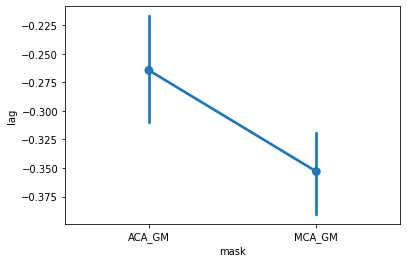

In [46]:
plac = df[df.drug == 'plac']
sns.pointplot(x = 'mask',
             y = 'lag',
            errorbar=('ci', 68),
              data = plac)

In [47]:
mod = smf.ols(formula='lag ~ mask', data=plac).fit()
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lag   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.398
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.124
Time:                        15:32:53   Log-Likelihood:                -56.343
No. Observations:                 152   AIC:                             116.7
Df Residuals:                     150   BIC:                             122.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2644      0.040     -6.532      0.000      -0.344      -0.184
mask[T.MCA_GM]    -0.0886      0.057     -1.549      0.124      -0.202       0.024
==============================================================================
Omnibus:                       53.064   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.723
Skew:                          -1.388   Prob(JB):                     3.08e-33
Kurtosis:                       6.992   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""